In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
#from copy import deepcopy
%matplotlib inline

In [23]:
import matplotlib.pylab as pylab

params = {'axes.labelsize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'legend.fontsize': 'xx-large',
          #'font.size': 16,
          'axes.titlesize': 'xx-large',
          'figure.titlesize': 'xx-large',
        #   'figure.supxlabel': 'x-large',
        #   'figure.supylabel': 'x-large'
          }
pylab.rcParams.update(params)

In [24]:
df_atla = pd.read_csv('PPO agent 100 alts over 1000+200 2-3-21 results\KPIs.csv',
                      header=0,
                      index_col=0)

In [25]:
df_atla.columns

Index(['baseline', 'SAC adversary BScaledSum mean diff 1-15-15',
       'dynamic_untargeted_acg', 'Optimal myBB no init',
       'untargeted_binary_myPGD_03_mask_time_scale_solar_and_consumption_eps',
       'untargeted_binary_myPGD_03_mask_time_REscale_solar_and_consumption_eps_clipped_adv_obs'],
      dtype='object')

In [26]:
df_atla = df_atla.drop(columns=['untargeted_binary_myPGD_03_mask_time_scale_solar_and_consumption_eps'])

Calculate adversarial regret by subtracting the baseline KPIs from the other entries

In [27]:
mask = df_atla.columns[~df_atla.columns.str.contains('baseline')]
df_atla[mask] = df_atla[mask].sub(df_atla['baseline'].values, axis='rows') 
df_atla.rename(columns=lambda name: name + '_atla', inplace=True)

In [28]:
df_conv = pd.read_csv('20 bin PPO 500 results\KPIs.csv',
                      header=0,
                      index_col=0,
                      usecols=[
                          'cost_function',
                          'baseline',
                          'untargeted_acg',
                          'optimal_myBB',
                          'SAC adversary BScaledSum mean diff 1-15-15',
                          'untargeted_binary_myPGD_03_mask_time_scale_solar_and_consumption_eps'
                      ],)

In [29]:
mask = df_conv.columns[~df_conv.columns.str.contains('baseline')]
df_conv[mask] = df_conv[mask].sub(df_conv['baseline'].values, axis='rows')
df_conv.rename(columns=lambda name: name + '_conv', inplace=True)

In [30]:
df_regret = pd.concat([df_atla,df_conv],axis='columns')

In [31]:
key_KPIs = ['electricity_consumption_total','ramping_average','daily_peak_average','cost_total']
la_mask = df_regret.columns[df_regret.columns.str.contains('SAC')]
bb_mask = df_regret.columns[df_regret.columns.str.contains('BB')]
acg_mask = df_regret.columns[df_regret.columns.str.contains('acg')]
pgd_mask = df_regret.columns[df_regret.columns.str.contains('PGD')]
legend_names = ['ATLA','Conventional']

Text(0.5, 0, 'Normalized KPI Difference from Clean Values')

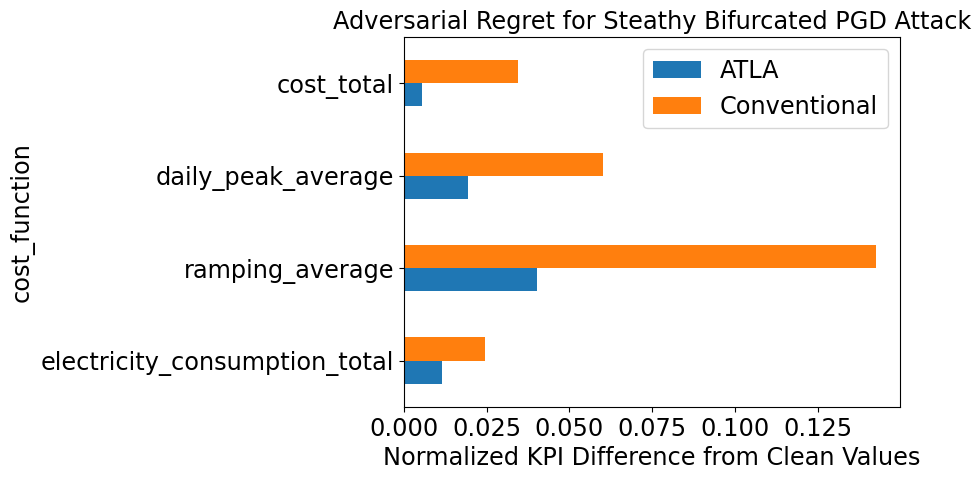

In [32]:
ax = df_regret[pgd_mask].loc[key_KPIs].plot.barh(title='Adversarial Regret for Steathy Bifurcated PGD Attack')
ax.legend(legend_names)
ax.set_xlabel('Normalized KPI Difference from Clean Values')

In [33]:
df_regret.columns

Index(['baseline_atla', 'SAC adversary BScaledSum mean diff 1-15-15_atla',
       'dynamic_untargeted_acg_atla', 'Optimal myBB no init_atla',
       'untargeted_binary_myPGD_03_mask_time_REscale_solar_and_consumption_eps_clipped_adv_obs_atla',
       'baseline_conv', 'untargeted_acg_conv', 'optimal_myBB_conv',
       'SAC adversary BScaledSum mean diff 1-15-15_conv',
       'untargeted_binary_myPGD_03_mask_time_scale_solar_and_consumption_eps_conv'],
      dtype='object')

In [34]:
kpi_diff = df_regret[['baseline_atla','baseline_conv']].sub(df_regret['baseline_conv'].values, axis='rows')

In [35]:
kpi_diff.loc[key_KPIs].T.values

array([[0.02847633, 0.02413681, 0.02336553, 0.01610963],
       [0.        , 0.        , 0.        , 0.        ]])

This took an hour...

In [36]:
# Create a 2D array for the errors
errors_2d = kpi_diff.loc[key_KPIs].T.values
# Create a 3D array for the errors of form [column,upper/lower bound, error value for bar]
errors = np.zeros((2, 2, errors_2d.shape[1]))  # 2 for the number of bars
errors[1, :, :] = 0  # lower errors
errors[0, 0, :] = errors_2d[1, :]  # upper errors for the first bar
errors[0, 1, :] = errors_2d[0, :]  # upper errors for the second bar

In [37]:
errors

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.02847633, 0.02413681, 0.02336553, 0.01610963]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]])

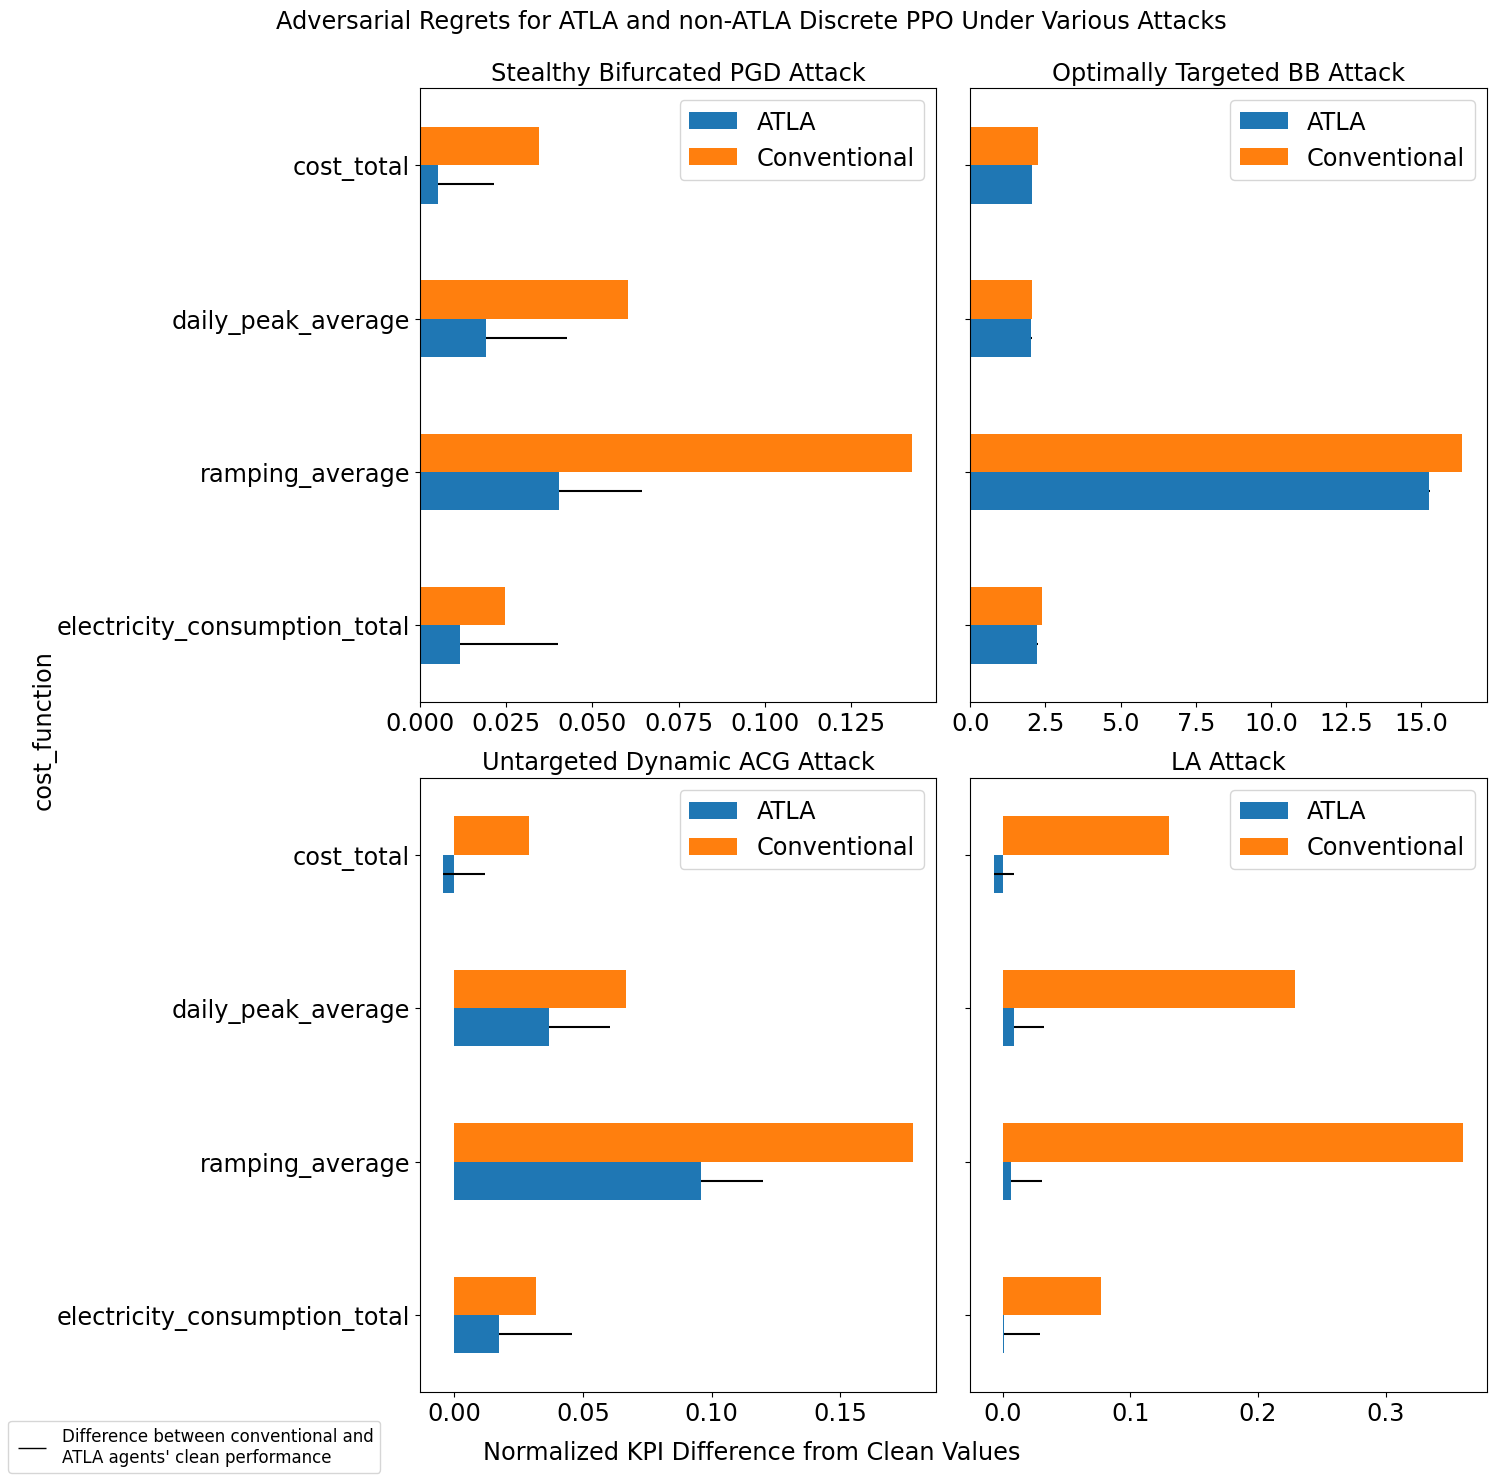

In [38]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15,15)
fig.suptitle('Adversarial Regrets for ATLA and non-ATLA Discrete PPO Under Various Attacks\n',
             fontsize='xx-large')
fig.supxlabel('Normalized KPI Difference from Clean Values',
              fontsize='xx-large')
fig.supylabel('cost_function',
              fontsize='xx-large')

errorbar_legend = mlines.Line2D([], [], color='black', 
                                marker='_', 
                                linestyle='None', 
                                markersize=20, 
                                label='Difference between conventional and\nATLA agents\' clean performance')

plt.figlegend(handles=[errorbar_legend], 
              loc='lower left', 
              fontsize='large') #show errorbar legend
#PGD
plt.subplot(2, 2, 1) #(row, col, plt#)
ax = df_regret[pgd_mask].loc[key_KPIs].plot.barh(title='Stealthy Bifurcated PGD Attack',
                                                 ax=plt.gca(),
                                                 ylabel=None,
                                                 xerr=errors
                                                 )
ax.legend(legend_names)
ax.set_ylabel(None) #remove xlabel since there's one for the whole figure

#optimal mybb
plt.subplot(2, 2, 2) #(row, col, plt#)
ax = df_regret[bb_mask].loc[key_KPIs].plot.barh(title='Optimally Targeted BB Attack',
                                                ax=plt.gca(),
                                                ylabel=None,
                                                xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)

#Dynamic uACG
plt.subplot(2, 2, 3) #(row, col, plt#)
ax = df_regret[acg_mask].loc[key_KPIs].plot.barh(title='Untargeted Dynamic ACG Attack',
                                                 ax=plt.gca(),
                                                 ylabel=None,
                                                 xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)

#LA
plt.subplot(2, 2, 4) #(row, col, plt#)
ax = df_regret[la_mask].loc[key_KPIs].plot.barh(title='LA Attack',
                                                ax=plt.gca(),
                                                ylabel=None,
                                                xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)
#remove yticks on right plots
axs[0, 1].yaxis.set_tick_params(labelleft=False)
axs[1, 1].yaxis.set_tick_params(labelleft=False)

plt.tight_layout() #makes the layout...make sense? prevents whitespace and overlap

In [39]:
pub_KPIs = ['electricity_consumption_total','ramping_average','daily_peak_average',]

In [40]:
# Create a 2D array for the errors
errors_2d = kpi_diff.loc[pub_KPIs].T.values
# Create a 3D array for the errors of form [column,upper/lower bound, error value for bar]
errors = np.zeros((2, 2, errors_2d.shape[1]))  # 2 for the number of bars
errors[1, :, :] = 0  # lower errors
errors[0, 0, :] = errors_2d[1, :]  # upper errors for the first bar
errors[0, 1, :] = errors_2d[0, :]  # upper errors for the second bar

In [42]:
errors

array([[[0.        , 0.        , 0.        ],
        [0.02847633, 0.02413681, 0.02336553]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

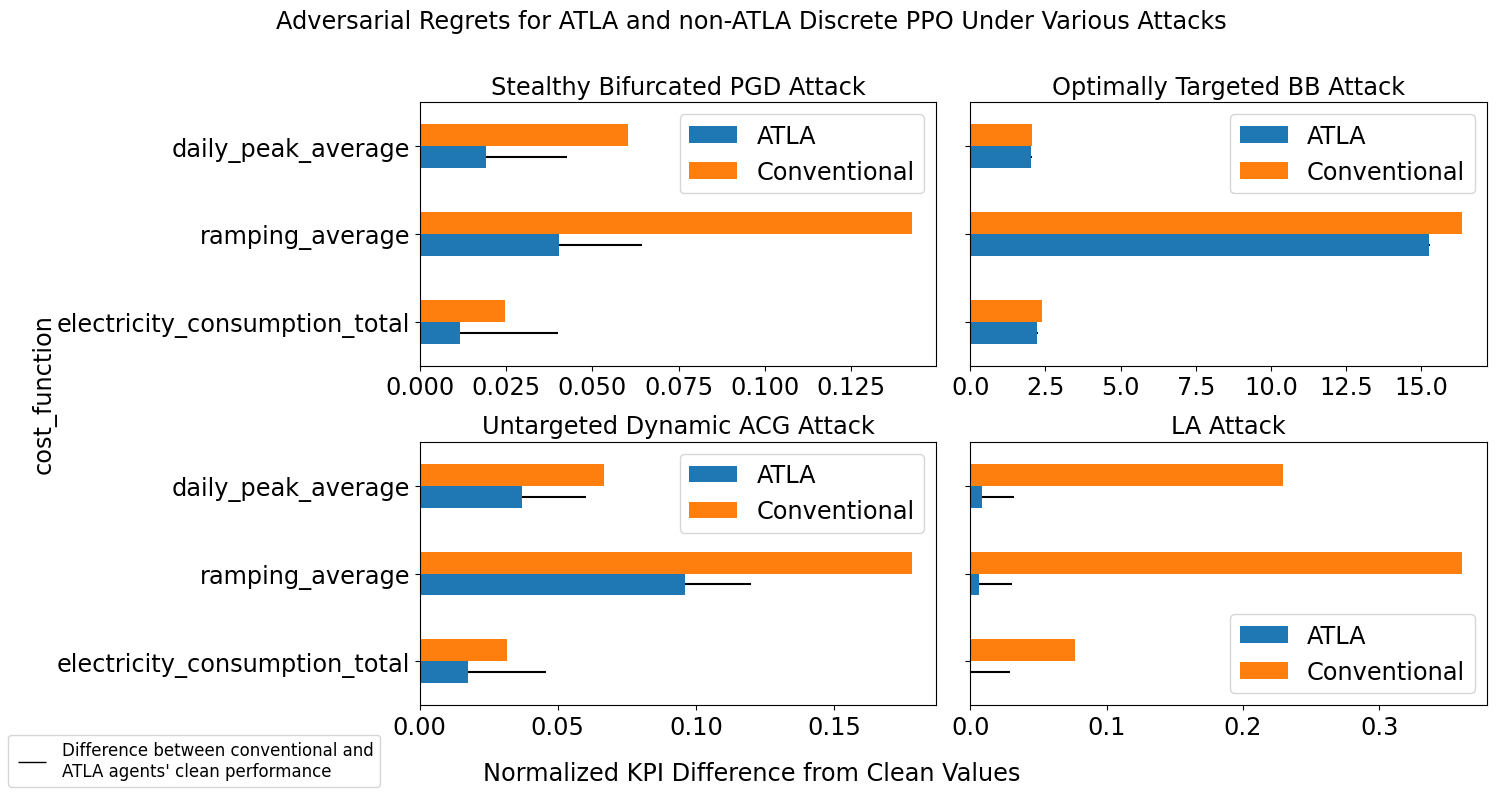

In [46]:

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15,8)
fig.suptitle('Adversarial Regrets for ATLA and non-ATLA Discrete PPO Under Various Attacks\n',
             fontsize='xx-large')
fig.supxlabel('Normalized KPI Difference from Clean Values',
              fontsize='xx-large')
fig.supylabel('cost_function',
              fontsize='xx-large')

errorbar_legend = mlines.Line2D([], [], color='black', 
                                marker='_', 
                                linestyle='None', 
                                markersize=20, 
                                label='Difference between conventional and\nATLA agents\' clean performance')

plt.figlegend(handles=[errorbar_legend], 
              loc='lower left', 
              fontsize='large') #show errorbar legend
#PGD
plt.subplot(2, 2, 1) #(row, col, plt#)
ax = df_regret[pgd_mask].loc[pub_KPIs].plot.barh(title='Stealthy Bifurcated PGD Attack',
                                                 ax=plt.gca(),
                                                 ylabel=None,
                                                 xerr=errors
                                                 )
ax.legend(legend_names)
ax.set_ylabel(None) #remove xlabel since there's one for the whole figure

#optimal mybb
plt.subplot(2, 2, 2) #(row, col, plt#)
ax = df_regret[bb_mask].loc[pub_KPIs].plot.barh(title='Optimally Targeted BB Attack',
                                                ax=plt.gca(),
                                                ylabel=None,
                                                xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)

#Dynamic uACG
plt.subplot(2, 2, 3) #(row, col, plt#)
ax = df_regret[acg_mask].loc[pub_KPIs].plot.barh(title='Untargeted Dynamic ACG Attack',
                                                 ax=plt.gca(),
                                                 ylabel=None,
                                                 xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)

#LA
plt.subplot(2, 2, 4) #(row, col, plt#)
ax = df_regret[la_mask].loc[pub_KPIs].plot.barh(title='LA Attack',
                                                ax=plt.gca(),
                                                ylabel=None,
                                                xerr=errors)
ax.legend(legend_names)
ax.set_ylabel(None)
#remove yticks on right plots
axs[0, 1].yaxis.set_tick_params(labelleft=False)
axs[1, 1].yaxis.set_tick_params(labelleft=False)

plt.tight_layout() #makes the layout...make sense? prevents whitespace and overlap